# [Crocoddyl Documentation](https://gepettoweb.laas.fr/doc/loco-3d/crocoddyl/master/doxygen-html/classcrocoddyl_1_1ActuationModelAbstractTpl.html#a9eaa72658ba1c065ecd7efcca8b6af72)

In [ ]:
!pip install crocoddyl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


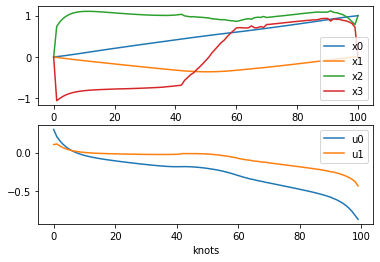

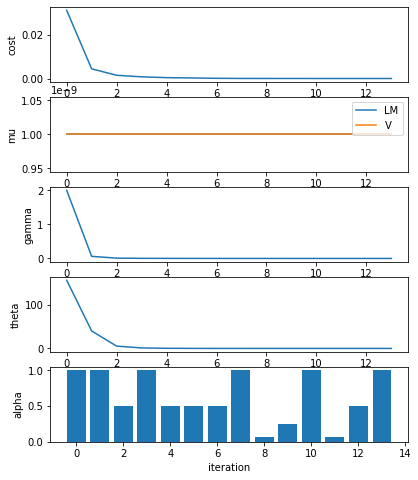

In [ ]:
import os
import sys
import crocoddyl
import numpy as np
import example_robot_data
from crocoddyl.utils.pendulum import CostModelDoublePendulum, ActuationModelDoublePendulum

WITHDISPLAY = 'display' in sys.argv or 'CROCODDYL_DISPLAY' in os.environ
WITHPLOT = 'plot' in sys.argv or 'CROCODDYL_PLOT' in os.environ
WITHPLOT = True

# Loading the double pendulum model
pendulum = example_robot_data.load('double_pendulum')
model = pendulum.model

state = crocoddyl.StateMultibody(model)
actuation = crocoddyl.ActuationModelFull(state)

nu = actuation.nu
runningCostModel = crocoddyl.CostModelSum(state, nu)
terminalCostModel = crocoddyl.CostModelSum(state, nu)

xRef =  np.array([1, 0, 1, 0])
xResidual = crocoddyl.ResidualModelState(state, xRef, nu)
xActivation = crocoddyl.ActivationModelWeightedQuad(np.array([1.] * 4))

z = .7
lb = np.array(xRef) + np.array([-z, -z, -z, -z])
ub = np.array(xRef) + np.array([z, z, z, z])
bounds = crocoddyl.ActivationBounds(lb, ub)

x = 1.5
w = np.array([x]*4)
xQuadBar = crocoddyl.ActivationModelWeightedQuadraticBarrier(bounds, w)
xBarCost = crocoddyl.CostModelResidual(state, xQuadBar, xResidual)

uResidual = crocoddyl.ResidualModelControl(state, nu)
xRegCost = crocoddyl.CostModelResidual(state, xActivation, xResidual)
uActivation = crocoddyl.ActivationModelWeightedQuad(np.array([0.1] * 2))
uRegCost = crocoddyl.CostModelResidual(state, uActivation, uResidual)

# xPendCost = CostModelDoublePendulum(state, crocoddyl.ActivationModelWeightedQuad(np.array([1.] * 4 + [0.1] * 2)), nu)

dt = 1e-2

runningCostModel.addCost("uReg", uRegCost, 1e-4 / dt)
# runningCostModel.addCost("xGoal", xRegCost, 1e-3 / dt)
runningCostModel.addCost("xBar", xBarCost, 1e-6 / dt)
terminalCostModel.addCost("xGoal", xRegCost, 100.)

runningModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuation, runningCostModel), dt)
terminalModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuation, terminalCostModel), dt)

# Creating the shooting problem and the FDDP solver
T = 100
x0 = np.array([0, 0., 0., 0.])
problem = crocoddyl.ShootingProblem(x0, [runningModel] * T, terminalModel)
solver = crocoddyl.SolverFDDP(problem)

cameraTF = [1.4, 0., 0.2, 0.5, 0.5, 0.5, 0.5]
if WITHDISPLAY and WITHPLOT:
    display = crocoddyl.GepettoDisplay(pendulum, 4, 4, cameraTF, False)
    solver.setCallbacks([crocoddyl.CallbackLogger(), crocoddyl.CallbackVerbose(), crocoddyl.CallbackDisplay(display)])
elif WITHDISPLAY:
    display = crocoddyl.GepettoDisplay(pendulum, 4, 4, cameraTF, False)
    solver.setCallbacks([crocoddyl.CallbackVerbose(), crocoddyl.CallbackDisplay(display)])
elif WITHPLOT:
    solver.setCallbacks([crocoddyl.CallbackLogger(), crocoddyl.CallbackVerbose()])
else:
    solver.setCallbacks([crocoddyl.CallbackVerbose()])

# Solving the problem with the FDDP solver
solver.solve()

# Plotting the entire motion
if WITHPLOT:
    log = solver.getCallbacks()[0]
    crocoddyl.plotOCSolution(log.xs, log.us, figIndex=1, show=False)
    crocoddyl.plotConvergence(log.costs, log.u_regs, log.x_regs, log.grads, log.stops, log.steps, figIndex=2)

# Display the entire motion
if WITHDISPLAY:
    display = crocoddyl.GepettoDisplay(pendulum, floor=False)
    display.displayFromSolver(solver)
